In [50]:
import os 
import pandas as pd
import subprocess as sp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as mtick
import pyarrow.parquet as pq

In [51]:
# standardized paths
base_path = sp.getoutput('git rev-parse --show-toplevel')
eda_figures_path = os.path.join(base_path, 'eda' , 'eda_figures')
data_path = os.path.join(base_path, 'data')
csv_list = os.listdir(data_path)


In [52]:
df_list = []

for filename in csv_list:

    if filename.endswith('.csv'):
        df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)

    elif filename.endswith('.parquet'):
        df = pq.read_table(os.path.join(data_path,filename), index_col=None, header=0)
        df = df.to_pandas()
        
    df_list.append(df)

df_base = pd.concat(df_list, axis=0, ignore_index=True)

/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (58,60,62) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (17,60,62,64,66,68,70,72,74) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (58,60,62,64,66) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(data_path,filename), index_col=None, header=0)
/var/folders/qv/vr4x2m4s0m53q79m582_pwt00000gn/T/ipykernel_63469/938624743.py:6: DtypeWarning: Columns (17,56,58,60,62) have mixed types. Specify dtype option on import or set

## Number of Cases per Judge

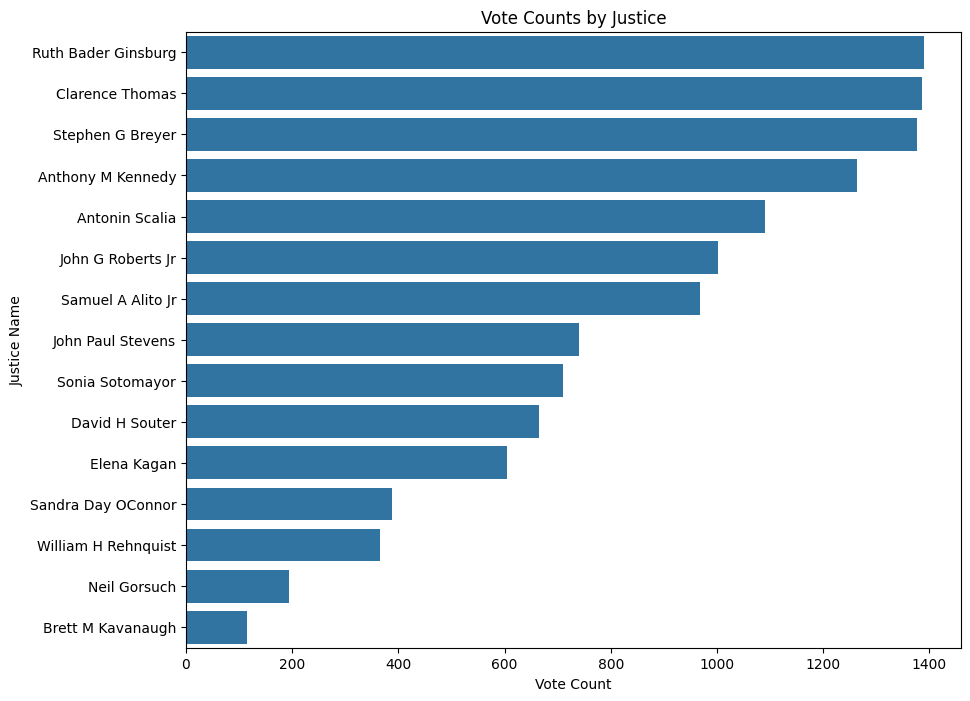

In [53]:
data = [ # dm'd from matt
        ('Ruth Bader Ginsburg', 1390),
        ('Clarence Thomas', 1387),
        ('Stephen G Breyer', 1376),
        ('Anthony M Kennedy', 1264),
        ('Antonin Scalia', 1090),
        ('John G Roberts Jr', 1003),
        ('Samuel A Alito Jr', 969),
        ('John Paul Stevens', 741),
        ('Sonia Sotomayor', 710),
        ('David H Souter', 665),
        ('Elena Kagan', 605),
        ('Sandra Day OConnor', 388),
        ('William H Rehnquist', 365),
        ('Neil Gorsuch', 195),
        ('Brett M Kavanaugh', 115)
        ]

df = pd.DataFrame(data, columns=['Name', 'Votes'])

default_blue = sns.color_palette()[0]

plt.figure(figsize=(10,8))
sns.barplot(x='Votes', y='Name', data=df, color=default_blue)
plt.title('Vote Counts by Justice')
plt.xlabel('Vote Count')
plt.ylabel('Justice Name')

plt.savefig(os.path.join(eda_figures_path, 'votes_per_justice.png'),
            bbox_inches='tight')

## Vote Rate Per Judge

## Histogram of utterance word count

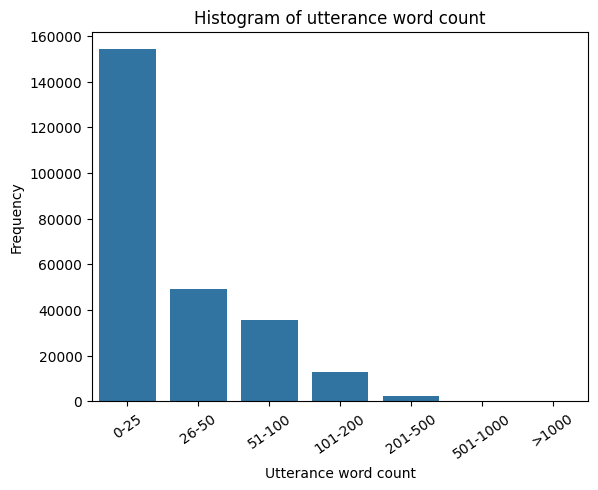

In [54]:
df = df_base.copy()

# Define a function to count words in a string
def count_words(s):
    return len(s.split())

# Apply the function to the text column and store the result in a new column
df['word_count'] = df['text'].apply(count_words)

bins = [0, 26, 51, 101, 201, 501, 1001, df['word_count'].max()]
labs = []
for i, lab in enumerate(bins[0:-1]):
    if i == 0:
        continue
    labs.append(f'{bins[i-1]}-{lab-1}')
labs.append(f'>{bins[-2] - 1}')
word_count_df = pd.DataFrame({'word_count': df['word_count'],
                              'word_count_group': pd.cut(df['word_count'], bins=bins, labels=labs)})

ax = sns.countplot(data=word_count_df, x='word_count_group', color=default_blue)
ax.tick_params(axis='x', labelrotation=35)
plt.xlabel('Utterance word count')
plt.ylabel('Frequency')
plt.title('Histogram of utterance word count');

plt.savefig(os.path.join(eda_figures_path, 'hist_utter_wordcount.png'),
            bbox_inches='tight')


## Number of utterances by case

In [55]:
df = df_base.copy()

In [56]:
df = df_base.copy()
df_utter_by_case = df.groupby(['case_id'], as_index=False).agg({'text': 'count'})

In [57]:
df_utter_by_case.sort_values('text', ascending=False)
#df_utter_by_case['text'].sum()

,case_id,text
887,2011_11-393,898
413,2005_04-473,636
397,2005_04-1360,593
254,2003_02-1674,588
411,2005_04-373,484
...,...,...
818,2010_10-5258,62
975,2013_12-1163,61
1173,2016_15-1503,51
386,2005_04-1144,39


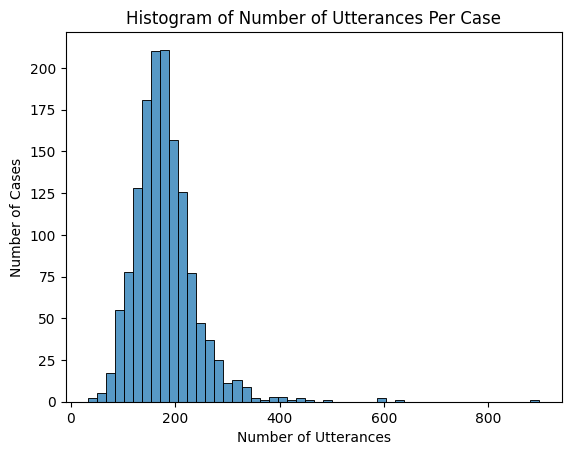

In [69]:

# Now use seaborn to plot a histogram of the aggregated data
sns.histplot(data=df_utter_by_case, x='text', bins=50)
plt.title('Histogram of Number of Utterances Per Case')
plt.ylabel('Number of Cases')
plt.xlabel('Number of Utterances')

plt.savefig(os.path.join(eda_figures_path, 'hist_num_utterances_per_case.png'),
            bbox_inches='tight')


## Median length of utterance by case

In [59]:
df = df_base.copy()

In [60]:
# Define a function to count words in a string
def count_words(s):
    return len(s.split())

In [61]:
df['word_count'] = df['text'].apply(count_words)

In [62]:
df_utter_length_by_case = df.groupby(['case_id'], as_index=False).agg({'word_count': 'median'})

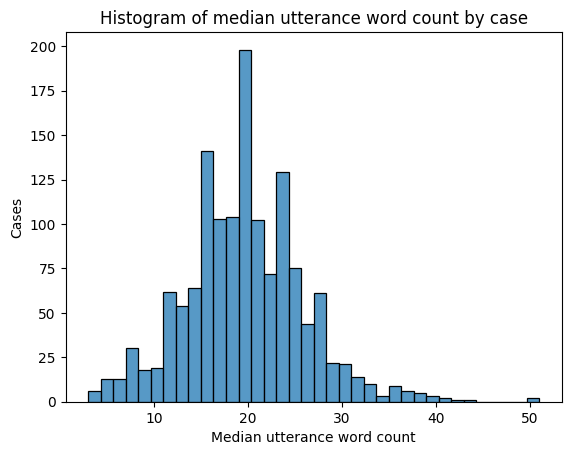

In [68]:
sns.histplot(data=df_utter_length_by_case, x='word_count')
plt.xlabel('Median utterance word count')
plt.ylabel('Cases')
plt.title('Histogram of median utterance word count by case');

plt.savefig(os.path.join(eda_figures_path, 'hist_median_num_utterances_per_case.png'),
            bbox_inches='tight')

## Win side

In [64]:
df = df_base.copy()

In [65]:
df_avg_case_outcome = (df.groupby(['case_id'], as_index=False)
                         .agg({'win_side': 'mean'}))

In [66]:
avg_case_outcome_all_data = (df.groupby(['case_id'], as_index=False)
                                  .agg({'win_side': 'mean'})
                                  ['win_side'].mean())

In [67]:
avg_case_outcome_all_data

0.6609686609686609